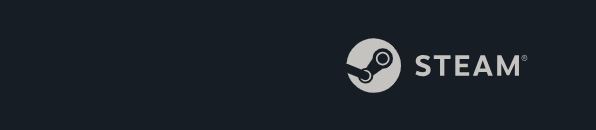

**Steam** is a digital video game distribution platform developed by Valve Corporation.<br>
It was launched in September 2003 as a way for Valve to provide automatic updates to its games, but was eventually expanded to include third-party games. <br> 

# Step 1 - Starting out our ETL Process
We started out by reading the Data Glossary to understand the structure and content of the three files provided with the project documentation: 

1.  **steam_games.json.gz**: This dataset contains comprehensive information about the games available on Steam. It encompasses details such as game titles, genres, release dates,etc... allowing us to gain insights into the **gaming catalog**. <br>

2.  **user_reviews.json**: The user reviews dataset provides user-generated feedback for Steam games. It contains data such as review text and rating feedback votes, enabling us to analyze user sentiments and experiences effectively.<br>

3.  **users_items.json**: In this dataset, we find data related to Steam users and their collections of in-game items. <br>
The insightful data from this dataset includes user preferences and the specific items they own.

Once we reviewed the structure, column definitions and set up, we proceeded to load them into Pandas Dataframes in order to access the information to transform and process.<br>
<br>

## 1.1 Games

We proceeded with the [ETL_games](ETL_games.ipynb) : **steam_games.json.gz** without inconvenients:<br>

The dataframe was named df_games, containing:<br>
*   120.445 rows
*   13 columns 
<br>
Using Data Wrangler, we get  a general idea of the dataset, it contains many missing values, most columns have up to 70% missing values in the dataset.<br>

>We will be deleting the missing information since, first we can't complete the missing information since it is diverse and the source is unknown.<br>
>Also, deleting missing information still provides us with more than enough information to our project. There is no loss. 

Now we are left with 22.530 rows and 13 columns  of information <br>
We now need to evaluate each column in order to decide which columns are important for the project and which columns can be deleted<br>
<br>
To follow, we will delete duplicates, only 2 registers were eliminated<br>

#### Now, we can start to define which columns we do need to keep. <br>
Columns that we already know that are necessary for the API functions: <br>

*   **publisher** for function **def developer**
*   **genres** for function **def user_for_genre**
*   **release date** for function **def best_developer_year**
*   **price** for function **def user_data**
*   **titles** for **def best_developer_year**
*   **id** identifies each game for its unique id value
*   **developer** for function **def developer**
##### These above columns, will be transformed and manipulated as part of the model.


#### Also, we can start to evaluate the information from other columns in order to delete columns that we don't need from our dataset.<br>
##### These are:
*   **app_name** similar information as in title
*   **url** does not bring value to the intended project
*   **tags** similar to genres and does not bring value to the intended project
*   **discount_price** does not bring value to the intended project
*   **reviews_url** does not bring value to the intended project
*   **specs** does not bring value to the intended project
*   **early access** does not bring value to the intended project

##### So all the above columns will be deleted   

Adding value to our data:
*   We convert **price** into an all float column, so all info about Free and promotions is turned into zeros.
*   We create a new column = **release_year** and delete the previous column **release_year** this new column will be used in the function **best_developer_year**
*   We drop all columns that don't add to the model or functions

#### Now there is one last column that we need to analyze and transform: 'genres'
##### genres
This column contains a list in each of the rows indicating to which genres does the game belong to. <br>
A **video game genre** is a category that groups games based on objectives, story, and gameplay.<br>
It helps users and developers identify games with similar styles and themes, like the intense challenges in action games or character development and quests in role-playing games.
In this column, for each game (row) we find a list of genres that the game features.<br>
This information will be used  in the function **user_for_genre** and our recommendation model<br>
But we will do this in our EDA, for now we will continue with our ETL stages.<br>

We store the transformed dataframe in [games.parquet](games.parquet) in data. 

## 1.2 User_Reviews
When moving on to our second file [ETL_user_reviews](ETL_user_reviews.ipynb), we were faced with our first challenge:<br>
The standard proceedure to read the file used in the first file resulted in error after error, because the data inside the .json file was not in the expected format.<br>
After investigating I learned that when the JSON file you are trying to load is not properly formatted (which is the case here), you can evaluate it line by line using **ast.literal_eval()**. <br>

After extensive searching and delving into Stack Overflow, I stumbled upon an article that was a breakthrough:

[Convert JSON to pd.DataFrame](https://stackoverflow.com/questions/55338899/convert-json-to-pd-dataframe/65427497#65427497)<br>
[JSONDecodeError](https://bobbyhadz.com/blog/python-jsondecodeerror-expecting-property-name-enclosed-in-double-quotes)<br>

The df_reviews dataframe (**user_reviews.json.gz**), contains:<br>
*   25.485 rows
*   3 columns
<br>
First we proceed to identify missing or duplicated values.
We encountered 623 duplicated registers, we validate that they are in fact duplicated and we finally delete the duplicated value keeping just the first occurence of the value.<br>
Then we move forward into the reviews column which is of the most interest to our project.<br>
 
It was easy to detect that the third column was a collection of list of dictionaries, and that data inside the last column is vital for the development of the sentiment analysis.<br>
```
df_reviews.iloc[100,2]
```
[{'funny': '',
  'posted': 'Posted October 13, 2014.',
  'last_edited': '',
  'item_id': '209870',
  'helpful': '3 of 8 people (38%) found this review helpful',
  'recommend': True,
  'review': 'Its a very fun game i recomend as its nearly like TITANFALL but its FREE!Play this game now'}]
  
#### We need to extract into columns the information present inside each field from the third column. <br> 
The fields into columns will be: funny, posted, last_edited,item_id,helpful,recommend, review.
After several attempts of different approaches I found a page with an explanation to a similar exercise that I adapted to resolve the nested list of dicctionaries into columns and registers combination.<br>
[Convert list of nested dictionary into Pandas dataframe](https://www.geeksforgeeks.org/python-convert-list-of-nested-dictionary-into-pandas-dataframe/)

Finally, the unnested df contains:
*   59.305 rows 
*   9 columns (['user_id', 'user_url', 'funny', 'posted', 'last_edited', 'item_id',
       'helpful', 'recommend', 'review_text']) 
So the final result is a dataframe with 25.485 rows, zero missing values, and columns:

* **user_id**: unique id identifier for each user in the platform
* **user_url**: url hosting the user profile in streamcommunity.
* **reviews**: contains a list of dictionaries. For each user, listing all the reviews posted by the user:
    * **funny**: indicates if another user qualifies as funny the users review
    * **posted**: date when the posting was made, format:  Posted April 21, 2011.
    * **last_edited**: date when the post was lastedited  
    * **item_id**: Is the game id, unique for each game
    * **helpful**: other users qualify if the review was render usefull
    * **recommend**: if a boolean value that indicates whether the user recommends the games or not.
    * **review**: Is the written review from the user that is post to the game url.

From all of these columns we found two columns with mostly missing values, missing values of the format '' where then changed to None. <br>
And after reviewing the amount of None values in all added columns, we decided to drop columns:
- **funny** with more than 86% of None values
- **last_edited** with more than 89% of None values

Then we proceeded to transform the column 'posted' from a 'Posted {Month} {day}, {year}' format into a new 'date' column.
In this column we found 9929 registers with the missing year, this were completed with the current year (2024) in order to be differentiate from the rest of the correct extracted values.
This 2024 year registers will not be considered for the **best_developer_year** function, but the remaining information still is available for the model.<br>

The remaining dataframe [reviews.parquet](reviews.parquet) summarizes 58.400 rows and 9 columns<br>

## 1.2 User_Items
Finaly, we moved on to our third and last file [ETL_items](ETL_items.ipynb): **users_items.json.gz**
We get the same error as the second file, so we need to load the information using the literal function from ast.<br>

We find yet again another column, **items** with nested list of dictionaries, and the information found in this column is the list of items (games) that each user purchased. So this is all valueable information that we need to develop our functions for our model.<br>
Before moving into unnesting the 'items' column we check once again for duplicates using the 'user_id' field.<br>
We found 1357 duplicated registers, that after validating that they were duplicated we proceeded to drop them keep the first occurrence.<br>

Finally, we proceed as with the previous reviews file, learning what is the structure of the data we need to extract from the **'items'** column<br>

The columns to add into our df_items are:
```
df_items.iloc[10,4]
```
[{'item_id': '4000',
  'item_name': "Garry's Mod",
  'playtime_forever': 2644,
  'playtime_2weeks': 0},
 {'item_id': '1250',
  'item_name': 'Killing Floor',
  'playtime_forever': 30266,
  'playtime_2weeks': 0},
 {'item_id': '35420',
  'item_name': 'Killing Floor Mod: Defence Alliance 2',
  'playtime_forever': 54,
  'playtime_2weeks': 0},

...
  'playtime_2weeks': 462},
 {'item_id': '444640',
  'item_name': 'Bloons TD Battles',
  'playtime_forever': 809,
  'playtime_2weeks': 0}]

  So we need to iterate through the item field for each row, in order to extract for each user the information:<br>
  - **'item_id'**: '444640' --> The unique identifier for the game, **game_id**<br>
  - **'item_name'**: 'Bloons TD Battles',--> the **Name** for the game<br>
  - **'playtime_forever'**: 809,--> the amount of total time the user played the game in **minutes**<br>
  - **'playtime_2weeks'**: 0}] --> the amount of total time the user played the game for the **last two weeks**<br>

So we run our code to convert for each user, this information into columns.<br>
<br>
We then obtain a dataframe of:<br>
- 5.153.209 rows<br>
- 8 columns<br>
<br>
Now we proceed to get more insight into the different columns and data in order to decide which column is relevant to our project and which column can be drop.<br>

#### Valuable information and disposable data
Now that we have some insight into the dataframe structure and information we can conclude that there are many columns we can drop in order to keep our data manageable and as compact as possible<br>
##### Columns to drop:<br>
-   **items_count** is a column that given the information can be calculated by request<br>
-   **steam_id** is the same exact value as **user_id**
-   **user_url** it is already contained in the review dataframe so in case it is needed it can be then pulled from that dataframe by request<br>
<br>

The remaining dataframe [items.parquet](items.parquet) summarizes 5.094.082 rows and 5 columns<br>


# Step 2 - EDA Analysis Summary
Now that we have the three files clean and ready, we can start getting some insight  into the data that will be used in our recommendation model project.<br>
Here you will find a summary of the work done in the EDA Analysis. <br>
For more detail information and visualizations:<br>

[EDA Games](EDA_games.ipynb)

[EDA Reviews](EDA_reviews.ipynb)

[EDA Items](EDA_items.ipynb)

## 2.1 Games

In the **EDA Analysis** we will mostly focus on:
-   search for outlier values
-   data statistics and description
-   data transformation
-   Variables:
    - item_id: this column contains the unique value identifier for the game.
    - item_name: this is the game name
    - developer: is a software developer specializing in video game development – the process and related disciplines of creating video games.
    - pucblisher: A video game publisher is a company that publishes video games that have been developed either internally by the publisher or externally by a video game developer
    - release_year: is the year the game was released
    - genres: this column contains a list of genres for each game, we will be transforming this data with different approaches<br>

### A summary of what you will find in the notebook:
#### Price
    *   Find out if our price information has outliers
    *   Most expensive games
    *   Average game price
    *   Price Range
    *   Price Distribution
    *   Price Statistics
 	
#### Relesease Date
    *   Year range
    *   Games released per year
    *	Top five years with more released games

#### Publishers
    *   Top ten publishers, largest amount of published games 

#### Developers
    *   Top ten developers, the developers with the largest amount of games published
    *   Least popular or relevant developers, developers with the smallest amount of published games    *   Least important publishers, publishers with the smallest amount of published games 

#### Genres
    *   Most popular genres, genres with the largest amount of published games
    *   Least popular genres, genres with the largest amount of published games

### Correlation Analysis between genres and price
##### Has the genres impact on the price of the games? 

## 2.2 Reviews

**The final purpose of this analysis is to define, for the recommendation model requested and the different functions, for each dataset and function the corresponding columns and data that will be requiered** 

### During the ETL process we already took care of:

[ETL_user_reviews](ETL_user_reviews.ipynb)<br>

-   missing values and data cleaning
-   removed columns of irrelevant information 
-   removed rows with non existant information or not valid.
-   removed duplicated values
-   corrected all datatypes for each and every data and column

### Sentiment Analysis
The dataset we will be using has already underwent the sentiment analysis transformation, so intead of working the EDA with reviews we will have a column named 'sentiment' that shows the result of the Sentiment Analyis process.<br>

### So in the **EDA Analysis** we will mostly focus on:
-   search for outlier values
-   data statistics and description
-   data transformation
-   Variables:
    - user_id: this column contains the unique value identifier for each of the users in Steam.
    - user_url: this column contains the url to the profile for each of the users in Steam.
    - item_id: this column contains the unique value identifier for the game.   
    - helpful: In this column other users qualify if the review was render usefull<br>
    - recommend: This column is a boolean value that indicates whether the user recommends the games or not. 
    - date: is the date when review was posted. From this column we extract the column year
    - year: is the year the game was released
    - sentiment: this column contains the sentiment analysis classification value<br>
        0 --> Negative
        1 --> Neutral
        2 --> Positive

### A summary of what you will find in the notebook:
#### user_id
-   Total number of users on the platform.
-   Calculation of the average number of reviews per user.
-   Exploration of the distribution of the number of reviews per user.
-   Determination of the user with the highest number of reviews.
-   Identification of the user with the highest average number of reviews per year.

**Findings:**

*   Only 30% of the users in the Steam platform post reviews, this is 25.446 users
*   this 30% of the users post in average 2.3 reviews 
*   from this 30%, 53% of users post just one review
*   And Less than 2% from the users that post, post more than 8 reviews

#### item_id
-	How many games have reviews
-	What percentage of games have reviews from the total amount of games available in the platform
-   	Exploration of the distribution of the number of reviews per game
-	Average reviews per game
-	Identification of the top 10 games with the highest number of reviews
-	Games with more than 500 reviews

**Findings:**

*	16% of all registered games in the platform get reviews, 3.682 out of a total of 22.530.
*	15% of the games get between 1 and 12 reviews
*	The average review per game is 15 reviews	
*	67% of all the reviews are concentrated in just 12 games.

### Helpful
In this column other users qualify if the review was render usefull<br>
This is how many users have qualify the posted review useful.<br>
We are going to transform this column in order to get some insight on how other users render their rating of the user's review

**Findings:**
* Most reviews are not rated by other users, **61% of them are not rated**
* 17% of the rated reviews are render helpful by other users

## Recommend and Sentiment Analysis
**We conducted a bivariate analyisis**<br>

In the case of this two variables we are going to run the EDA as a bivariable analysis.<br>
This column is a boolean value that indicates whether the user recommends the games or not. This is if the recomendation is positive there is a 1 and if not a zero.<br>
We can use this column to evaluate or validate our sentiment analysis result. <br>
- How many users post a positive recommendation<br>
- How many users post a positive recommendation and a positive sentiment review<br>
- How many positive recommendations match to a positive sentiment<br>
- How many negative sentiment match to a negative recommendation<br>

#### Sentiment Analysis and Recommend
We are going to consider that all neutral sentiments are positive, and we are going to conduct a type of accuracy score to the sentiment analysis using NLKT and TextBlob libraries given the recommend column.<br>
This is to analyze in some way how accurate our sentiment analysis is.<br>

**Findings**
From the accuracy evaluation between both sentiment Analysis we conclude that the NLTK analysis is the best performing.<br>
Now we can review for the results against the recommend from the user:<br>

* **Negatives** We can see that for the recommend True, this is that the user recommends the game even if the review is negative, the percentage of recommend is about 70%, this is that most users although they consider the game not good, they still recommended the game.<br>
* **Neutral** In this case, the review being neutral is not a negative review, so it is not a surprise that users still recommend the game even if the review is not bad. And also, our sentiment analysis performs very good recognizing positive reviews but not so good in classifying neutral reviews.<br>
* **Positive** In this case, we confirm what our accuracy test showed, our sentiment analysis is good at classifying positive reviews, and positive reviews match on 91% of the cases.
Given that our analysis was a fast and simple approach with many opportunities, the results are good, all things considered<br>


## 2.3 Items
### During the ETL process we already took care of:

[ETL_items](ETL_items.ipynb)<br>

-   missing values and data cleaning
-   removed columns of irrelevant information 
-   removed rows with non existant information or not valid.
-   removed duplicated values
-   corrected all datatypes for each and every data and column

### So in the **EDA Analysis** we will mostly focus on:
-   search for outlier values
-   data statistics and description
-   data transformation
-   Variables:
    - user_id: This user_id is the unique identifier for each of the users in the platform column 
    - item_id: unique identifier for the game in the platform
    - item_name: name of the game or app
    - playtime_forever: The total number of minutes played "on record"
    - playtime_2weeks: The total number of minutes played on the last 2 weeks
-   Multivariable analysis:

### A summary of what you will find in the notebook:

#### User_id
This user_id is the unique identifier for each of the users in the platform column
**Findings**
- How many users are registered in the platform

#### item_id
- How many games are items in the users accounts
- Percentage from the total amount of games
- Average amount of games per user
- Top 10 items most sold (most users have it)
- Top 10 Games most played in the last 2 weeks

#### Outliers for items_id per user

**Findings**
* The average amount of games per user are 71 games
* Over 50% of the users own more than 40 games each.
* There are only 39 users with more than 2000 games each, this will be considered outliers but they represent less than the 0.056%
* The **maximum amount** of games owned by a user is *7762 games*
- Top 10 items most sold (most users have it)

#### item_name
This is the name of the game.

### playtime_forever
The total number of minutes played "on record"
- 	Top 5 users with the most minutes played in total
-	Top 5 games with the most minutes played
-	Average number of minutes played by user
-	Average number of minutes per game

**Findings**
* The Top 10 games account for about 41% of the total played time.
* The average playtime per user is 1497 minutes
* 50% of all users play more than 887 minutes.
* The average minutes per games is 277 minutes
* 50% of the games are played over more than 90 minutes in average

### playtime_2weeks
The total number of minutes played "on record" for the last 2 weeks
- 	Top 5 users with the most minutes played in total
-	Top 5 games with the most minutes played
-	Average number of minutes played by user
-	Average number of minutes per game

# 3. Feature Engineering

## 3.1 Sentiment Analysis
To gain some insight and true value from our user's reviews we will conduct a Sentiment Analysis from the reviews of our users.
This **Sentiment Analysis** will then be used in our recommendation system, model.<br>
For this, we chose to work with NLTK pyhton libraries <br>
There is not a unique approach to Sentiment Analysis, all methods can deliver a good result. 
I our project we chose NLTK library and not TextBlob that is a much simpler approach:

NLTK (Natural Language Toolkit):

**Advantages**:
-   Provides a wide range of tools and resources for natural language processing tasks.
-   Flexible and customizable for advanced NLP tasks.
-   Well-established community and extensive documentation.

**Disadvantages**:
-   Requires more code and effort for simple tasks compared to TextBlob.
-   May be slower for certain tasks due to its comprehensive nature.

In our case we studied and implemented both methods, you can review in detail in [Feature Engineering](03.%20Feature%20Engineering.ipynb).

We proceeded following the process of:

1. **Data Preprocessing and Tokenization**: This step involves cleaning and preparing the text data for analysis. It includes tasks such as removing punctuation, converting text to lowercase, removing stop words, and handling special characters.
Tokenization involves breaking down the text into individual words or tokens.
> We chose to perform this by creating a new column, named 'clean_review' and passing a function to the 'review_text' column  content and storing this transformation, for each element in the 'clean_review' 

2. **Sentiment Analysis**: Once the text data is prepared, sentiment analysis can be performed. There are several libraries and techniques available for sentiment analysis, including lexicon-based approaches, machine learning models, and deep learning models.
We set to define the sentiment classification into:
*   Negative = 0 for all values where compound_score was under - 0.05
*   Neutral = 1 all other results nor negative nor positive and none values or emojis.
*   Positive = 2 for all values where compound_score was above 0.05
> For our work, we chose to work with Vader. ALthough Textblob is a suitable solution because is much faster and simpler, when comparing both results, the only disadvanage of NLTK was the use of resources, the model runs slow, but the outcome is better.
>NLTK is more assertive in classifing negative and positive sentiments, but even better for neurtral classification.
In the [Feature Engineering](03.%20Feature%20Engineering.ipynb) you can review in detail the process for both approaches and our analysis, and then in the [EDA_reviews](EDA_reviews.ipynb) you can find the comparison of the results for both approaches and more exploration.<br>

3. **Analysis, Visualization and Summary**: Finally, the results of the sentiment analysis can be analyzed and visualized to gain insights from the data.

* Resources:<br>
[Sentiment Analysis](https://www.youtube.com/watch?v=O_B7XLfx0ic)

[NLTK Sentiment Analysis](https://www.youtube.com/watch?v=XFoehWRzG-I)

[Sentiment_Analysis_article](https://www.kdnuggets.com/sentiment-analysis-in-python-going-beyond-bag-of-words)

## 3.2  Rating our users reviews in the reviews dataframe.
## Reviews Transformation
### We need to transform our users reviews, recommend button result and the rating from helpful (where other users qualified the review (rate) into a rating) in order to feed our recommendation system.<br>
For this we create a function that will consider all three items, when existing and average a rating that expresses the user's review in numbers.<br>
Overall, this function assigns a rating score based on the provided values for 'rate', 'sentiment', and 'recommend', considering different combinations of these values and following specific rules.<br>
*   If the 'rate' column is greater than 0:
        -If the 'recommend' column is 0:
            -If the 'sentiment' column is 0, the rating score is set to 0.
            -If the 'sentiment' column is 1, the rating score is calculated as 50 times the 'rate'.
            -If the 'sentiment' column is 2, the rating score is calculated as 75 times the 'rate'.
        -If the 'recommend' column is 1:
            -If the 'sentiment' column is 0, the rating score is calculated as 50 times the 'rate'.
            -If the 'sentiment' column is 1, the rating score is calculated as 75 times the 'rate'.
            -If the 'sentiment' column is 2, the rating score is calculated as 100 times the 'rate'.
*   If the 'rate' column is 0:
    - If the 'recommend' column is 0:
        - If the 'sentiment' column is 0, the rating score is set to 0.
        - If the 'sentiment' column is 1, the rating score is set to 50.
        - If the 'sentiment' column is 2, the rating score is set to 75.
    - If the 'recommend' column is 1:
        - If the 'sentiment' column is 0, the rating score is set to 50.
        - If the 'sentiment' column is 1, the rating score is set to 75.
        - If the 'sentiment' column is 2, the rating score is set to 100
Then we normalize this rating into a 1 to 5 score.<br>

This rating will be the engine for our Collaborative Filtering Recommender System and the Machine Learning KNN Recommender <br>

## 3.3 Collaborative Filtering Recommender

## 3.4 Machine Learning KNN Recommender

## 3.5 API Functions 
In this section of our notebook we are going to experiment and work on our requested API Functions.<br>
These are:<br>
1. **Developer** number of games and percentage of Free content by developer by year.<br>
2. **User_data**: how much money has the user spent, what percentage, from the total number of games the user owns, has the user recommended from the reviews.recommend and how many games he purchased.<br>
3. **User_for_genres**: this function must return the user with the largest amount of minutes for the given genres and a list of minutes accumulated per year since the release date<br>
4. **Best_developer_year**: this function returns the top 3 developers based on the largest amount of recommendations for the given year (reviews.recommend = True and sentiment = 2)<br>
5. **Developer_Reviews_Analyis**: given a developer, the function returns a dicctionary with developer as keys and the amount of Positive and Negative Sentiment Reviews.<br> 

In the notebook [Feature Engineering](03.%20Feature%20Engineering.ipynb) is the complete step by step to create each of this functions, and their input dataframes.

[Deploy an API in Render](https://medium.com/@iamgreatdiro/deploying-apis-on-render-a-step-by-step-guide-4ebe6a3fd377)